In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import shap, datetime, warnings
warnings.filterwarnings('ignore')

In [20]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))

In [ ]:
sentiment_cols = [i for i in df.columns if any(x in i for x in ['Article Count', 'Tone', 'llm'])] + [i for i in df.columns if i.startswith('c') or i.startswith('v')]

y_cols = ['Volume']
y = df[y_cols]

# Train/test splitting
split_val  = round(0.8 * len(y))
split_test = round(0.9 * len(y))

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

model = pickle.load(open(f'../../output/models/LightGBM/lightgbm_sentiment_only.pkl', 'rb'))

x_cols = sentiment_cols
x = df[x_cols]
x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]

# Normalize the features to [0,1]
sc2 = MinMaxScaler(feature_range=(0, 1))

x_train = sc2.fit_transform(x_train)
x_val   = sc2.transform(x_val)
x_test  = sc2.transform(x_test)
x_eval = np.concatenate((x_val, x_test), axis=0)

# sample rows from x_eval
np.random.seed(42)
x_sample = x_eval[np.random.choice(x_eval.shape[0], size=5000, replace=False), :]

In [ ]:
# shap values
explainer = shap.TreeExplainer(model, x_sample, feature_names=x.columns)
shap_values = explainer(x_sample, check_additivity=False)
pickle.dump(shap_values, open('../../output/models/LightGBM/sentiment_shap_values.pkl', 'wb'))

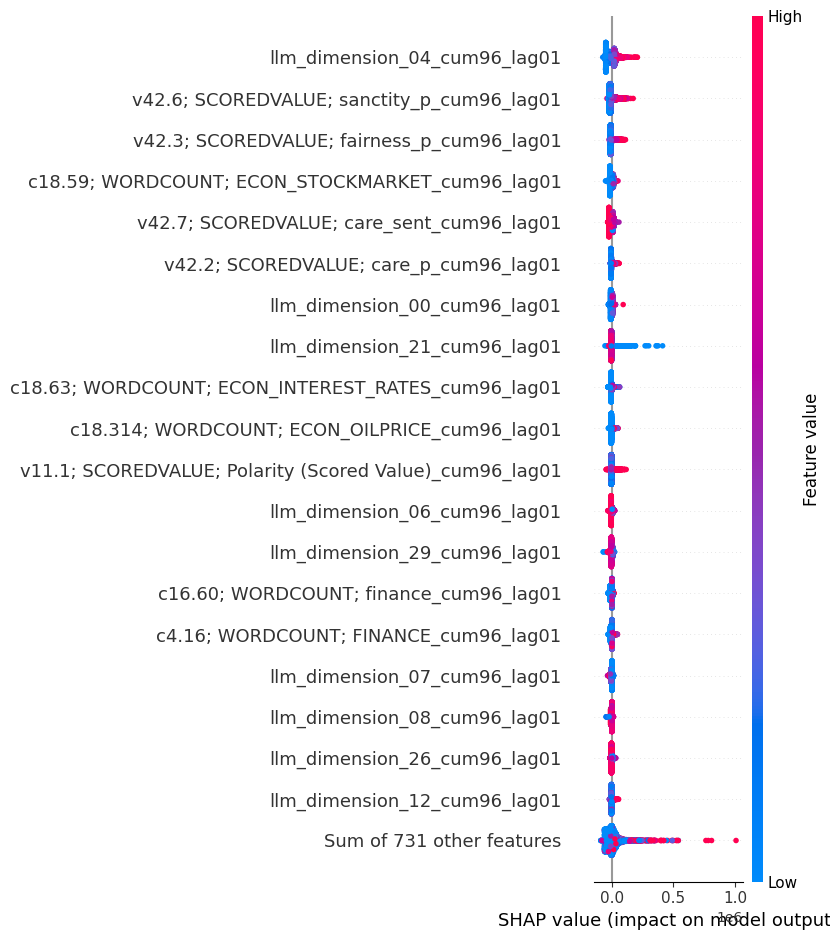

In [28]:
shap_values = pickle.load(open('../../output/models/LightGBM/sentiment_shap_values.pkl', 'rb'))
fig = plt.figure(figsize=(20, 15))
fig.add_axes(shap.plots.beeswarm(shap_values, max_display=20, show=False))
fig.tight_layout()
fig.savefig('../../output/shap_beeswarm_sentiment.pdf')

In [30]:
sentiment_vars = [i.replace('_lag01','').replace('_cum04','').replace('_cum16','').replace('_cum48','').replace('_cum96','') for i in sentiment_cols]
sentiment_vars = list(set(sentiment_vars))

df_shap = pd.DataFrame(shap_values.values, columns=x.columns)

for i in sentiment_vars:
    df_shap[i] = df_shap[[j for j in df_shap.columns if i in j]].sum(axis=1)
df_shap
df_shap = df_shap[sentiment_vars]
df_agg = df_shap.mean(axis=0).to_frame(name='Mean Shapley Value').reset_index()

df_agg

,index,Mean Shapley Value
0,llm_dimension_17,141.795767
1,c18.137; WORDCOUNT; TRIAL,20.962704
2,llm_dimension_03,-112.866420
3,v20.4; SCOREDVALUE; Level2Negative (Scored Value),195.926376
4,v42.9; SCOREDVALUE; loyalty_sent,110.898176
...,...,...
145,c18.286; WORDCOUNT; ECON_BUBBLE,0.000000
146,llm_dimension_16,303.407289
147,c18.62; WORDCOUNT; ECON_HOUSING_PRICES,67.788764
148,c18.58; WORDCOUNT; ECON_CURRENCY_EXCHANGE_RATE,43.747488


In [37]:
pd.DataFrame(shap_values.values, columns=x.columns)

,Article Count_cum04_lag01,Article Count_cum16_lag01,Article Count_cum48_lag01,Article Count_cum96_lag01,Article Count_lag01,Tone_cum04_lag01,Tone_cum16_lag01,Tone_cum48_lag01,Tone_cum96_lag01,Tone_lag01,...,v42.8; SCOREDVALUE; fairness_sent_cum04_lag01,v42.8; SCOREDVALUE; fairness_sent_cum16_lag01,v42.8; SCOREDVALUE; fairness_sent_cum48_lag01,v42.8; SCOREDVALUE; fairness_sent_cum96_lag01,v42.8; SCOREDVALUE; fairness_sent_lag01,v42.9; SCOREDVALUE; loyalty_sent_cum04_lag01,v42.9; SCOREDVALUE; loyalty_sent_cum16_lag01,v42.9; SCOREDVALUE; loyalty_sent_cum48_lag01,v42.9; SCOREDVALUE; loyalty_sent_cum96_lag01,v42.9; SCOREDVALUE; loyalty_sent_lag01
0,0.0,0.0,7.764647,-0.003469,0.0,64.246807,406.368521,441.591583,682.534261,0.0,...,44.417834,1109.381579,115.954535,1071.202947,0.0,33.684102,231.207111,265.619142,-2129.247649,0.0
1,0.0,0.0,7.113215,0.465167,0.0,-26.789585,-39.914898,-603.714117,-13340.338966,0.0,...,-0.466186,-391.704286,-189.998956,-214.562221,0.0,50.016409,37.003647,254.439993,3562.967519,0.0
2,0.0,0.0,5.946409,0.065578,0.0,-13.191393,-99.963441,511.490409,1233.805991,0.0,...,-0.884689,-209.033927,-300.658351,-390.121105,0.0,-1.303711,-16.228329,-10.319126,-91.743525,0.0
3,0.0,0.0,5.946409,0.065578,0.0,-13.191393,-99.963441,511.490409,1233.805991,0.0,...,-0.884689,-209.033927,-300.658351,-390.121105,0.0,-1.303711,-16.228329,-10.319126,-91.743525,0.0
4,0.0,0.0,11.046795,0.060233,0.0,116.583772,-93.437646,704.972964,1697.064894,0.0,...,-41.048322,-1246.661646,-399.046223,-1743.402092,0.0,76.017198,-94.243625,993.355805,252.256753,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,-1.302865,-0.007364,0.0,3.078594,298.835154,-1681.943986,-1669.541581,0.0,...,13.712178,2908.299114,350.966543,453.557917,0.0,50.215392,794.731929,213.215982,-3045.513081,0.0
4996,0.0,0.0,5.946409,-3.117091,0.0,-13.170337,-95.249816,482.878396,1351.387678,0.0,...,-1.000945,337.554002,93.132662,-132.754338,0.0,-1.529251,102.192872,30.337023,109.465476,0.0
4997,0.0,0.0,13.496133,-0.031890,0.0,115.000576,197.858493,152.653121,1545.843595,0.0,...,44.881967,10650.724702,76.152618,1280.990316,0.0,-2.860041,1222.342527,2047.162745,1073.250618,0.0
4998,0.0,0.0,5.946409,-0.218722,0.0,-23.777462,-96.253351,455.116063,2210.391393,0.0,...,-1.958558,-243.618272,-746.278051,-297.038162,0.0,-3.958114,-31.556331,137.274979,-925.150677,0.0


In [36]:
pd.DataFrame(shap_values.values, columns=x.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
Article Count_cum04_lag01,5000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Article Count_cum16_lag01,5000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Article Count_cum48_lag01,5000.0,-3.400233,100.794998,-1122.503151,5.946409,6.733076,7.113215,265.864591
Article Count_cum96_lag01,5000.0,-0.554834,14.575459,-488.345249,0.043085,0.224270,0.680310,26.048874
Article Count_lag01,5000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
v42.9; SCOREDVALUE; loyalty_sent_cum04_lag01,5000.0,10.697224,195.667661,-1919.149162,-5.811885,-1.832385,16.014353,12210.254445
v42.9; SCOREDVALUE; loyalty_sent_cum16_lag01,5000.0,31.387799,411.246431,-4613.415270,-40.658930,-10.783218,83.101422,4532.566588
v42.9; SCOREDVALUE; loyalty_sent_cum48_lag01,5000.0,162.789121,533.962351,-7769.561218,-10.319126,151.041367,331.317968,8268.189549
v42.9; SCOREDVALUE; loyalty_sent_cum96_lag01,5000.0,-93.975968,4133.121938,-19912.790097,-1902.412955,-24.965286,2254.752353,26151.477565


In [ ]:
df_clean = df_agg[df_agg['index'].isin([
    'Tone',
    'Article Count',
    'v11.1; SCOREDVALUE; Polarity (Scored Value)',
    'v10.2; SCOREDVALUE; Negative (Scored Value)',
    'v10.1; SCOREDVALUE; Positive (Scored Value)',
    'c18.314; WORDCOUNT; ECON_OILPRICE',
    'c18.60; WORDCOUNT; ECON_EARNINGSREPORT',
    'v42.7; SCOREDVALUE; care_sent',
    'v42.11; SCOREDVALUE; sanctity_sent',
])]

df_clean.index = df_clean['index']
df_clean.drop(columns=['index'], inplace=True)
df_clean.rename(index = {
    'v11.1; SCOREDVALUE; Polarity (Scored Value)': 'Polarity',
    'v10.2; SCOREDVALUE; Negative (Scored Value)': 'Negative',
    'v10.1; SCOREDVALUE; Positive (Scored Value)': 'Positive',
    'c18.314; WORDCOUNT; ECON_OILPRICE': 'Oil Price',
    'c18.60; WORDCOUNT; ECON_EARNINGSREPORT': 'Earnings Report',
    'v42.7; SCOREDVALUE; care_sent': 'Care (+) / Harm (-)',
    'v42.11; SCOREDVALUE; sanctity_sent': 'Sanctity (+) / Degradation (-)'
}, inplace=True)

df_clean

,index,Mean Shapley Value
index,,
Article Count,Article Count,-3.955066
Polarity,v11.1; SCOREDVALUE; Polarity (Scored Value),309.089912
Positive,v10.1; SCOREDVALUE; Positive (Scored Value),436.981430
Care (+) / Harm (-),v42.7; SCOREDVALUE; care_sent,2146.810771
Sanctity (+) / Degradation (-),v42.11; SCOREDVALUE; sanctity_sent,287.234281
Tone,Tone,679.722271
Oil Price,c18.314; WORDCOUNT; ECON_OILPRICE,-597.619386
Negative,v10.2; SCOREDVALUE; Negative (Scored Value),-31.362173
Earnings Report,c18.60; WORDCOUNT; ECON_EARNINGSREPORT,-0.203522


In [42]:
# Find the index position of the variable 'llm_dimension_04_cum96_lag01'
var = 'llm_dimension_04_cum96_lag01'
var_index = x.columns.get_loc(var)
var_index

33

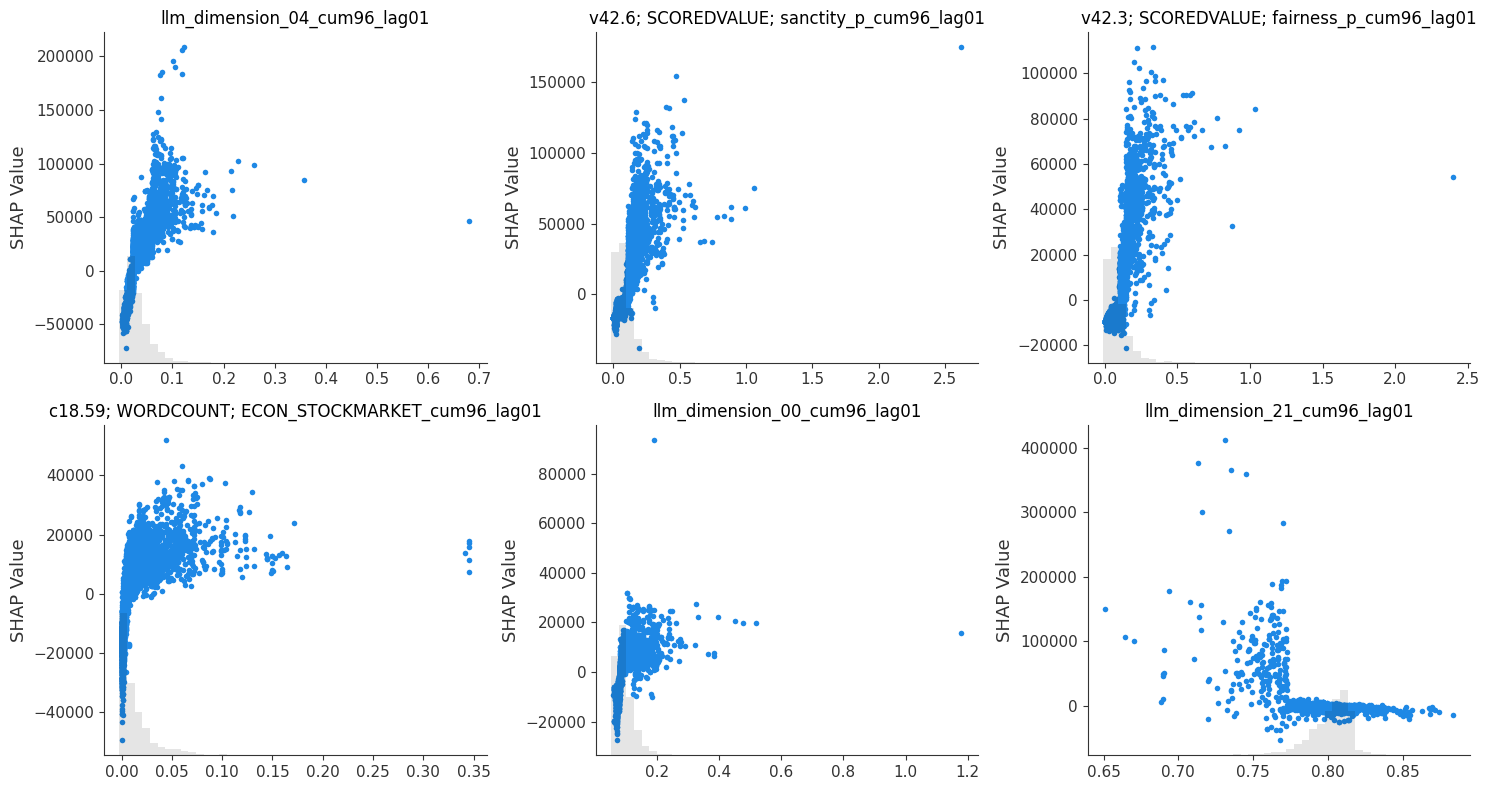

In [14]:
to_plot = ['llm_dimension_04_cum96_lag01', 'v42.6; SCOREDVALUE; sanctity_p_cum96_lag01', 'v42.3; SCOREDVALUE; fairness_p_cum96_lag01', 'c18.59; WORDCOUNT; ECON_STOCKMARKET_cum96_lag01', 'llm_dimension_00_cum96_lag01', 'llm_dimension_21_cum96_lag01']

# Calculate number of rows and columns for the subplot grid
n_plots = len(to_plot)
n_cols = 3  # You can adjust this based on your preference
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division to ensure all plots fit

# Create a large figure
fig = plt.figure(figsize=(15, 4 * n_rows))

# Create and save each dependence plot
for i, var in enumerate(to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    shap.plots.scatter(
        shap_values[:, var],
        show=False,  # Don't show individual plots
        ax=plt.gca()
    )
    plt.title(f"{var}")
    plt.ylabel("SHAP Value")
    plt.xlabel("")

# Adjust layout
plt.tight_layout()

# Save combined figure
#plt.savefig(r'../output/gbm_shap_dependence_plots_combined.png', dpi=300, bbox_inches='tight')
plt.show()

(0.0, 0.3)

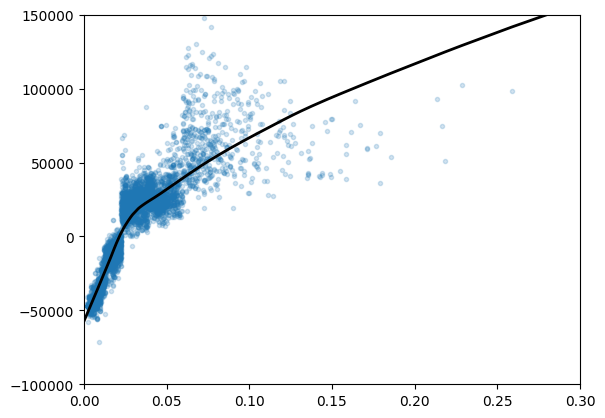

In [64]:
sns.regplot(
    x=shap_values[:, 33].data, 
    y=shap_values[:, 33].values,
    lowess=True,
    marker='.',
    scatter_kws={'alpha': 0.2},  # Adjust marker size and transparency
    line_kws={'color': 'black', 'linewidth': 2}  # Add a regression line
    )
plt.ylim(-100000,150000)
plt.xlim(0, 0.3)